In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from starfish.set import settings

In [3]:
def var_filter(fisher,lcdm,neff_fixed):
    df=fisher.copy()
    if lcdm:
        df=df.drop('w0',axis=0)
        df=df.drop('w0',axis=1)
        df=df.drop('wa',axis=0)
        df=df.drop('wa',axis=1)
    if neff_fixed:
        df=df.drop('N_eff',axis=0)
        df=df.drop('N_eff',axis=1)

    return df

# JPAS + PFS

In [4]:
fisher1=var_filter(pd.read_excel('../data/CMB/all.xlsx',header=0,index_col=0),lcdm=True,neff_fixed=False)
fisher2=pd.read_excel('../data/combined/cmb+pelg-lcdm-free.xlsx',header=0,index_col=0)
fisher3=pd.read_excel('../data/combined/cmb+pelg+jmul-lcdm-free.xlsx',header=0,index_col=0)

cov1=pd.DataFrame(np.linalg.inv(fisher1.values),index=fisher1.index,columns=fisher1.columns)
cov1_marg=cov1.drop('tau',axis=0)
cov1_marg=cov1_marg.drop('tau',axis=1)
fisher1=pd.DataFrame(np.linalg.inv(cov1_marg),index=fisher3.index,columns=fisher3.columns)

In [5]:
from getdist import plots
from getdist.gaussian_mixtures import GaussianND

gauss=[]
fisher=[fisher1,fisher2,fisher3,]
for f in fisher:
    g=GaussianND(settings.cosmo_value,f,is_inv_cov=True,names=settings.var_exp)
    g.paramNames.names[-2].name=r'$\sum m_\nu\;[\mathrm{eV}]$'
    g.paramNames.names[-2].label=''
    g.names=settings.var_exp
    gauss.append(g)

In [6]:
orders=[r'$h$',r'$\Omega_\mathrm{m,0}$',r'$\Omega_\mathrm{b,0}$',r'$\sigma_8$',r'$n_\mathrm{s}$',r'$\sum m_\nu\;[\mathrm{eV}]$',r'$N_\mathrm{eff}$']
err=[]
for f in fisher:
    cov=np.linalg.inv(f.values)
    err.append(np.sqrt(np.diag(cov)))
err_max=np.sort(np.stack(err,axis=0),axis=0)[-1,:]
lower=settings.cosmo_value-3*err_max
lower[-2]=0
limits=list(zip(lower,settings.cosmo_value+3*err_max))
d=dict(zip(settings.var_exp,limits))
m=dict(zip(settings.var_exp,settings.cosmo_value))

In [7]:
# '#887BB0','#A97155','#6B8E23','#4B6587',
palette=sns.color_palette(['mediumslateblue','forestgreen','gray'])
palette

[(0.4823529411764706, 0.40784313725490196, 0.9333333333333333),
 (0.13333333333333333, 0.5450980392156862, 0.13333333333333333),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)]

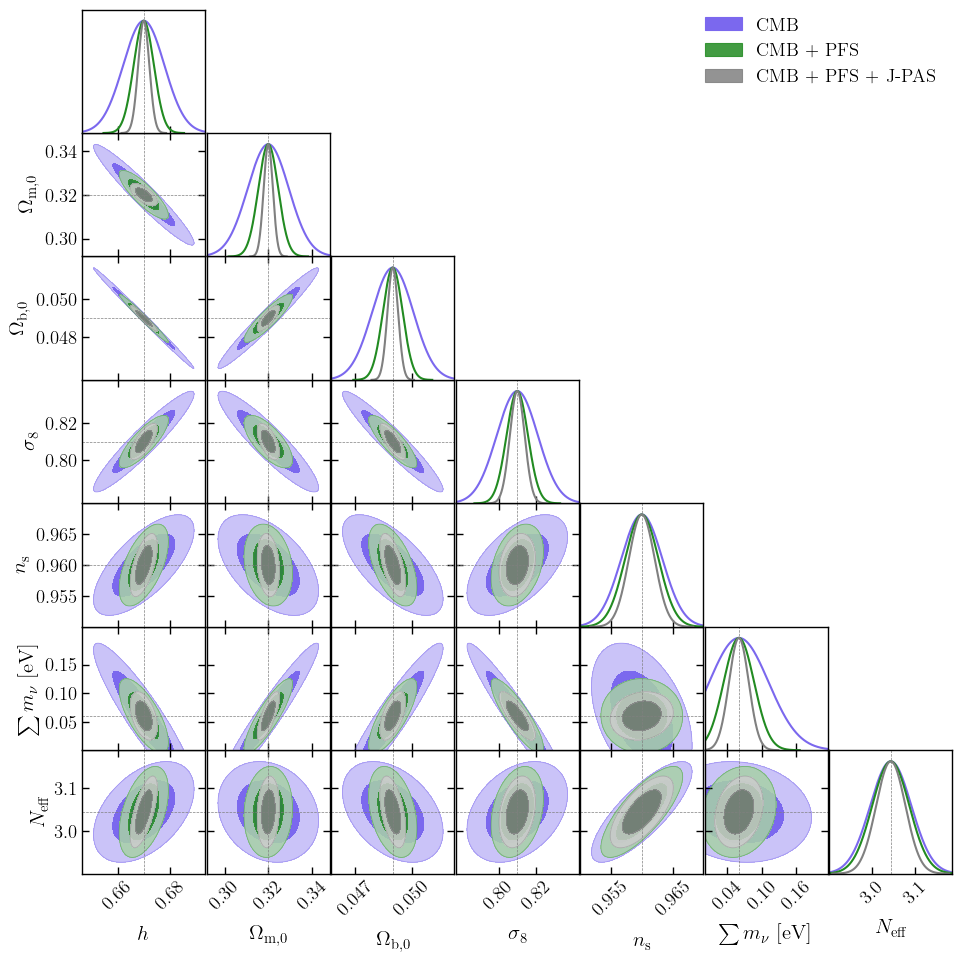

In [8]:
sns.set_context('paper',font_scale=2)
ploter=plots.get_subplot_plotter(width_inch=10,rc_sizes=True)
ploter.settings.tight_layout=True
ploter.settings.axis_tick_x_rotation=45
ploter.settings.figure_legend_frame=False
ploter.triangle_plot(
    gauss,
    params=orders,
    param_limits=d,
    filled=True,
    markers=m,
    marker_args={'color':'gray'},
    legend_labels=['CMB','CMB + PFS','CMB + PFS + J-PAS'],
    contour_colors=palette,
    contour_lws=[1.5,1.5,1.5],
    legend_loc='upper right')

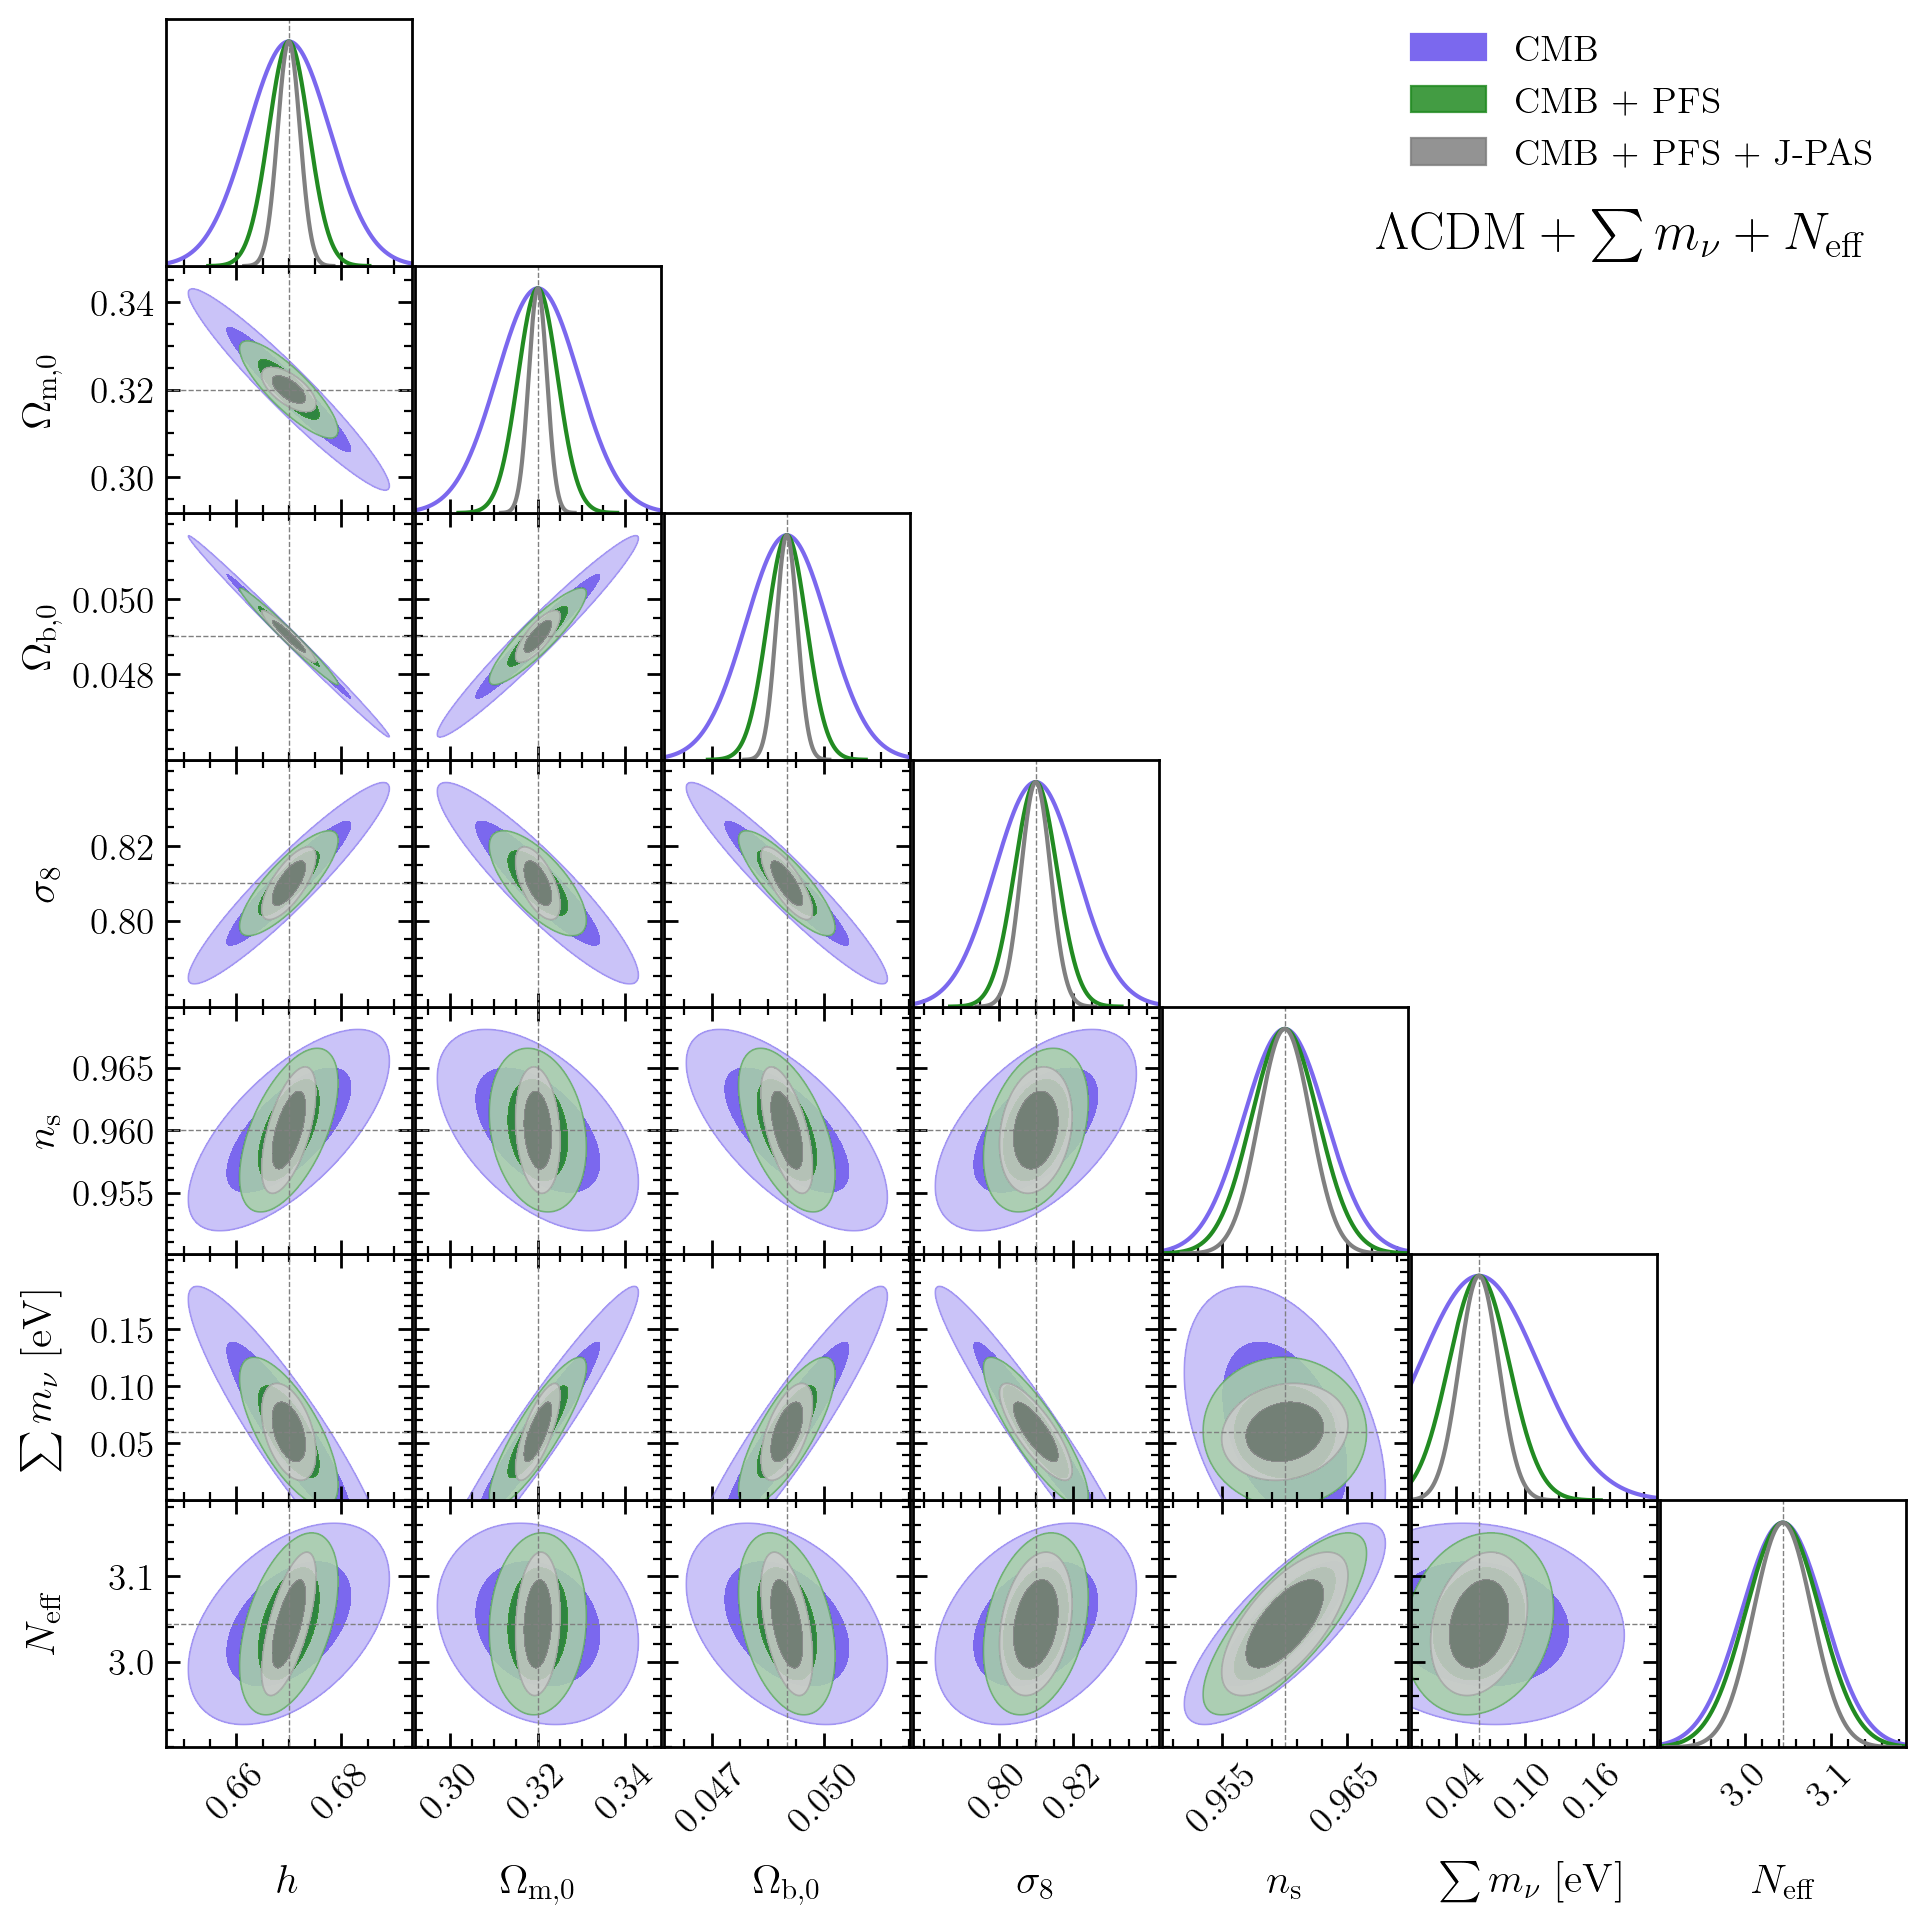

In [9]:
ploter.fig.set_dpi(200)
ploter.fig.align_labels()
for ax in ploter.fig.axes:
    ax.minorticks_on()
    ax.tick_params(which='major',length=5)
    ax.tick_params(which='minor',length=3)
y=len(orders)
axes=[]
start=0
for x in range(len(orders)):
    axes.append(ploter.fig.axes[start:start+y])
    start+=y
    y-=1
for col in axes:
    col[-1].yaxis.minorticks_off()
ploter.fig.text(0.95,0.85,r'$\Lambda\mathrm{CDM}+\sum m_\nu+N_\mathrm{eff}$',horizontalalignment='right', verticalalignment='bottom')
ploter.fig

In [10]:
ploter.fig.savefig('../fig/cmb+pelg+jmul-all-lcdm-free.pdf')